# Assignment 2: Taking the Pulse of the Atmosphere: CO<sub>2</sub> Concentrations
This assignment is due on 2025-10-09. Please put your answers within this notebook and share the completed notebook with the TAs rishudh@stanford.edu & jmells@stanford.edu using the "Share" banner located at the top right corner of this notebook. When sharing your notebook, please change the name of the notebook and add your name and sunetid (e.g., tpp_assignment_2_firstname_lastname_sunetid.ipynb) For help submitting, see the canvas walkthrough. If you are still having technical difficulties, email us before the deadline.


###**INTRODUCTION TO THE ASSIGNMENT**

In this week’s assignment we will analyze NASA's Orbiting Carbon Observatory-2 (OCO-2) satellite data with the goal of understanding how/why the concentration of CO<sub>2</sub> is changing in the atmosphere over space and time. We also want to consider the valid uses of this form of data.


###**DATA SETS**
We will use NASA's OCO-2 dataset. This dataset uses satellite data to provide monthly measurements of CO<sub>2</sub> concentration from January 2015 to December 2021. Instead of having a table with dates and monthly measurements of CO<sub>2</sub> concentration taken at one location, we have monthly measurements of CO<sub>2</sub> concentration at many times and many locations. We use a new data structure (a new way to organize the data) to make our analysis computationally efficient.

A widely adopted system is to consider a grid imposed on the surface of Earth, with latitude and longitude defining the grid and used to describe the locations – or points – on the grid. One value for the variable of interest (in this assignment CO<sub>2</sub> concentration) is provided at each gridpoint and each timestep. We describe our dataset as containing gridded data. (Note, the dataset will not always be a fully populated in space and time, so there will be missing values; i.e., not all gridpoints will have values at all timesteps.)

If you want to learn more about NASA's OCO2 dataset see: https://ocov2.jpl.nasa.gov/


###**Resolution**
The OCO-2 dataset which we use in this assignment, has a resolution of 0.5 deg x 0.625 deg, which would be approximately 55.5 km x 55 km at Stanford.

The OCO2 satellite measures CO<sub>2</sub> at a spatial resolution of 1.29 km x 2.25 km, but the dataset is gridded at a coarser resolution to have a continuous global coverage

####**Units:**
The unit for reporting the concentration of CO<sub>2</sub> is ppm (parts per million).

##**TOOLBOX**
All the Python functions and packages you will use in this assignment are in the toolbox for the course. We add new tools to the toolbox with each assignment as new ways of analyzing and visualizing data are introduced.

https://colab.research.google.com/drive/1-NE6VhGBa_0w9cdxfWXugt9ZkxxlF14w?usp=sharing

We will use the libraries redivis, numpy, pandas, matplotlib, xarray, cartopy, datetime to analyze this data (more information about these in the above linked toolbox).


## **Learning Goals for the Week**
(where the course learning goals are in plain text, and the focus this week is in italics)

● learn about the ways in which climate change and human activity are impacting planet Earth, *with a focus this week on the way human activity is resulting in CO<sub>2</sub> changes on the planet.*

● become familiar with the wide range of sensors available to study various components of the Earth system. These include sensors on satellites, aircraft, ground-based platforms, and deployed above or beneath the surface on land or water. *This week we will learn about the measurement of CO<sub>2</sub> in the atmosphere from satellites.*

● work with various sources of data, learning how to access, analyze, synthesize, and describe the data to quantify trends; think critically and creatively about how to project these trends into the future. *This week you will learn how to analyze gridded data.*

● become motivated to think about new sensors and new ways of using sensor data to study the planet. *This week you will consider the advantages and disadvantages of satellite forms of measuring CO<sub>2</sub>.*

## **In Class Set Up for Assignment**


#### 1) **Install and Import Packages**: numpy, pandas, matplotlib, xarray, cartopy, widgets, and datetime (See Toolbox)

In [1]:
#---Install Packages---
# copy this block verbatum. no changes needed.
!pip install redivis xarray numpy pandas geopandas cartopy ipywidgets rioxarray pykrige&> /dev/null
!pip install shapely --no-binary shapely &> /dev/null

In [2]:
import redivis
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cf
import datetime
from ipywidgets import widgets, interact
from shapely.geometry import mapping
from matplotlib.colors import LogNorm
matplotlib.rcParams['font.size'] = 14
import shapely
from pykrige.ok import OrdinaryKriging

#### 2) **Downloading and Reviewing the Data**

We are going to import the gridded data into a Python dataframe so that we can use tools in our toolbox for analysis. The variables you will have are time, location in terms of latitude and longitude, and the concentration of CO<sub>2</sub>.

Use the code below to download the entire dataset from redivis and organize it as an xarray dataframe called co2_data.

In [3]:
user = redivis.user("SDSS_data_repository")
dataset = user.dataset("geophysics_115_taking_the_pulse_of_the_planet:fg2x:v1_0")
table = dataset.table("atmosphere_data:9be7")

# Load table as a dataframe
df = table.to_pandas_dataframe(max_results=100)
df.head()

# This table contains file references, to download:
table.download_files('./taking_the_pulse_atmosphere_data/',overwrite=True)

# Here we load the xarray dataframe and store it in a variable
co2_data = xr.load_dataset('./taking_the_pulse_atmosphere_data/co2.nc')
co2_data

Please visit the URL below to authenticate with your Redivis account:
https://redivis.com/oauth/authorize?user_code=07905989f0ec9225ca7ec0ec21f08eb7


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ? files/s]

0.00 (?B/s)

<xarray.Dataset> Size: 44MB
Dimensions:  (time: 84, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 672B 2015-01-31 2015-02-28 ... 2021-12-31
  * lon      (lon) float64 3kB -179.8 -178.8 -177.8 -176.8 ... 177.2 178.2 179.2
  * lat      (lat) float64 1kB 89.75 88.75 87.75 86.75 ... -87.25 -88.25 -89.25
Data variables:
    co2      (time, lat, lon) float64 44MB 400.6 400.6 400.6 ... 411.5 411.5
Attributes:
    Description:    CO2 data
    Unit:           ppmv (part per million per volume)
    Data document:  https://disc.gsfc.nasa.gov/datasets/OCO2_GEOS_L3CO2_MONTH...

##### **a)** Open/view the dataframe and you will see the expected variables. Briefly summarize (1-2 sentences) what is contained in this dataframe that you will be working with.


The dataframe is a 3-dimensional Xarray with time, longitude, and latitude as its 3 dimensions. At any "coordinate point" of these 3 dimensions, a CO2 value is stored for the specific time and location.

## **The Start of Assignment: Data Analysis and Questions to Complete**

#### **1) ARE THERE SEASONAL EFFECTS AT THE GLOBAL SCALE?**

A common way to visualize satellite data is to show all the measurements for one specific time over all (or a subset) of the locations; we will refer to this as a "*map*" which displays a time slice of the gridded data. You can present the measurements in the map as individual values or interpolate across space to look at a continuous display.

**a) In Class (work & discuss in groups):** Using the Toolbox, create a map showing all the CO<sub>2</sub> concentration measurements at one time slice of your choosing. *Talk within your group to discuss what you see in the maps generated.*

Text(0.5, 0, 'Longitude')

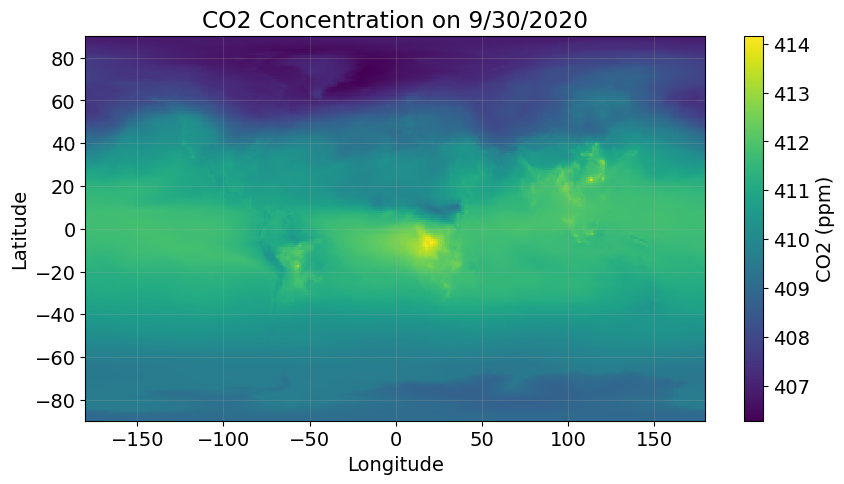

In [32]:
map = co2_data.co2.sel(time='2020-10-05', method='nearest')
fig, ax = plt.subplots(1,1, figsize=(10, 5))
map.plot(ax=ax, cbar_kwargs={'label': 'CO2 (ppm)'})
ax.grid(True, alpha=0.2)
ax.set_title('CO2 Concentration on 9/30/2020')
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

**b) In Class (work & discuss in groups):** Recallying what was observed in the Mauna Loa dataset, we should check to see if there are seasonal effects in the OCO-2 data. Conduct some analysis and generate whatever maps you need to determine if seasonal effects are present. *Talk within your group to discuss what you see in the maps generated.*

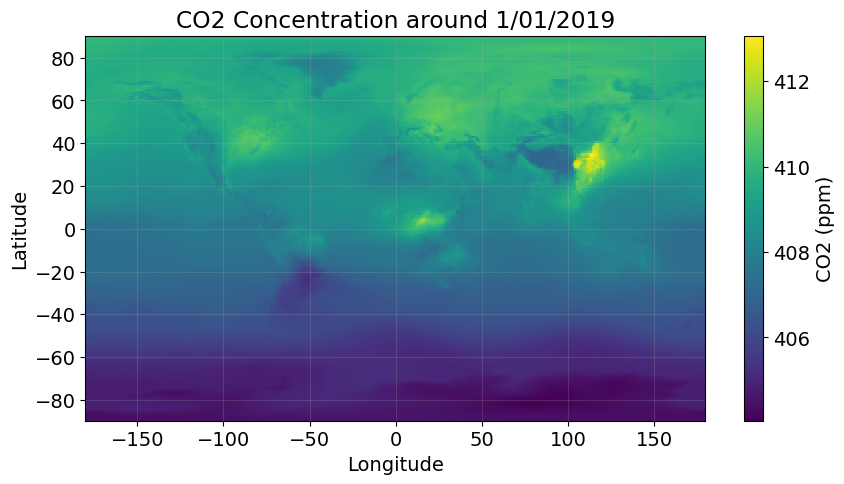

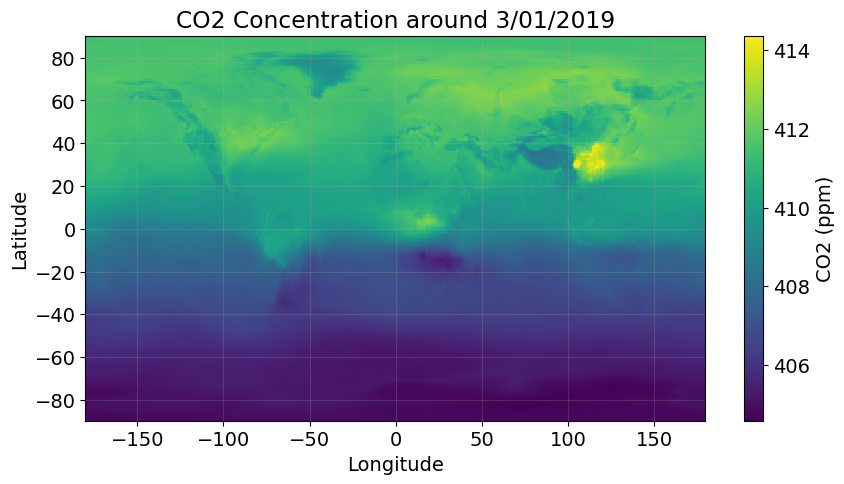

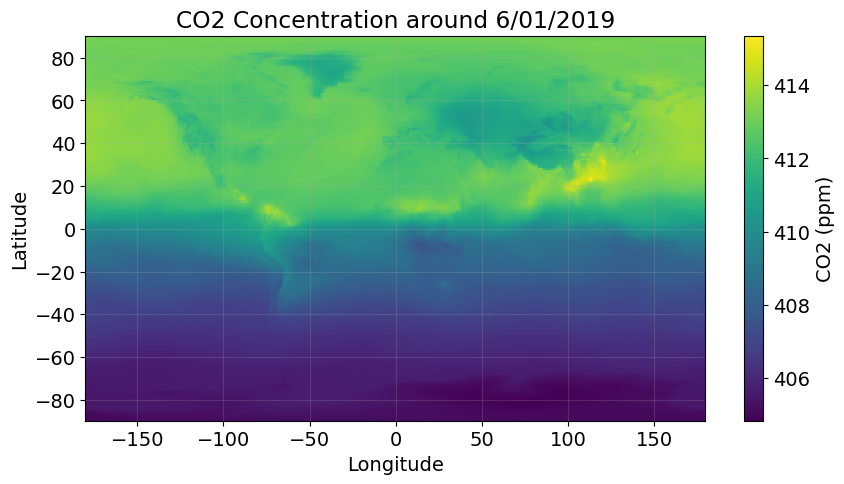

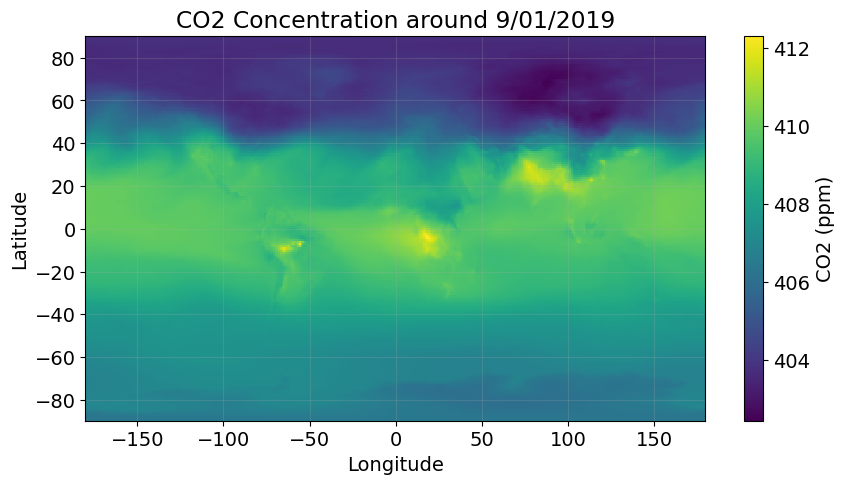

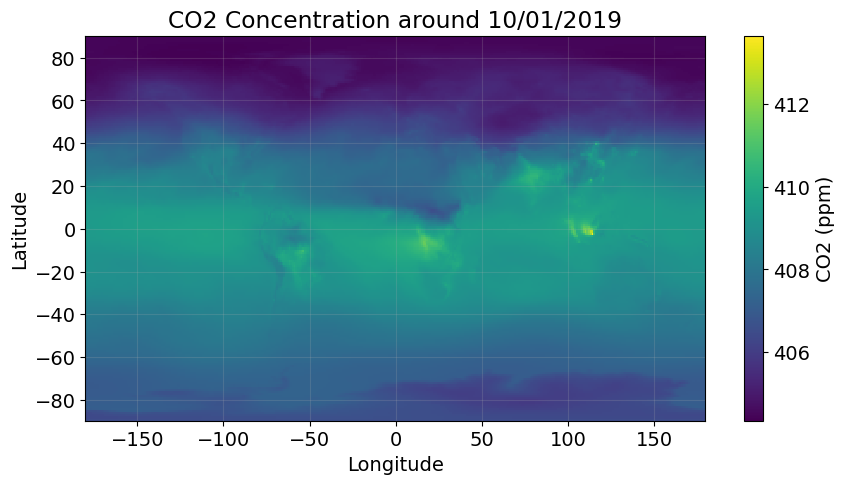

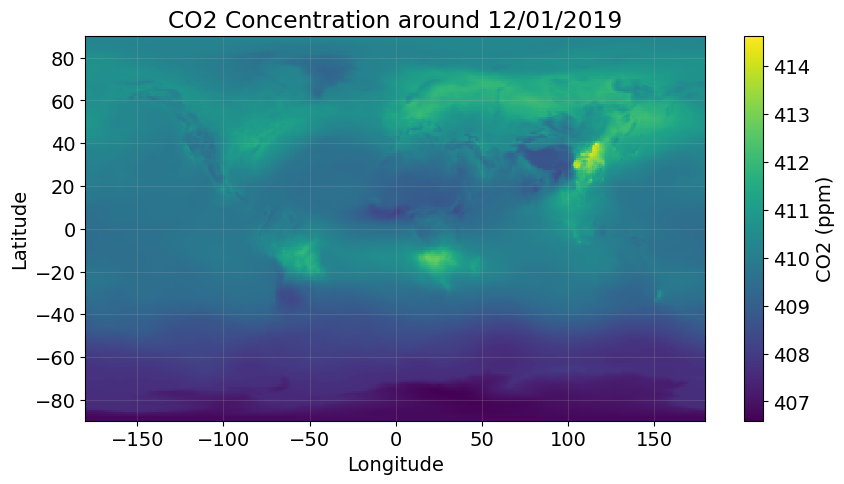

In [34]:
months = [1,3,6,9,10,12]

for i in months:
  map = co2_data.co2.sel(time=f'2019-{i}-01', method='nearest')
  fig, ax = plt.subplots(1,1, figsize=(10, 5))
  map.plot(ax=ax, cbar_kwargs={'label': 'CO2 (ppm)'})
  ax.set_title(f'CO2 Concentration around {i}/01/2019')
  ax.set_ylabel('Latitude')
  ax.set_xlabel('Longitude')
  ax.grid(True, alpha=0.2)

**c) Outside of Class:** Describe and explain your observations (4-6 sentences). Are they what you expected?

We can certainly see that there is seasonality in the data, which is consistent with what we saw last week. Looking at the bar of CO2 concentration on the right, colder months typically have a slightly lower concentration than warmer.

However, the assessment from the Mauna Loa data doesn't take into account that warmer months are not consistent around the globe. The northern hemisphere experiences summer when the southern hemisphere experiences winter, and vice versa. Thus, what this data also reveals is how the CO2 concentration changes in different locations (hemispheres) throughout the year.

Typically, we can see that each hemisphere has a lower CO2 concentration during its summer, which again is consistent with the idea that plants are able to perform photosynthesis and capture CO2 in warmer months.

However, what suprised me was that the southern hemisphere typically always has a lower CO2 concentration than the northern hemisphere, even during its colder months. This can likely be due to the fact that there is less land and humans occupying and emitting on such land in the southern hemisphere.

#### **2) WHAT ARE THE PRIMARY SOURCES AND SINKS OF CO<sub>2</sub> EMISSIONS?**

**a) In Class (work & discuss in groups):** Considering the spatial variation you see in the concentration of CO<sub>2</sub>  in different time slices, can you suggest anything about the emissions coming from different countries or parts of the world? In addition to looking at individual time slices, conduct whatever level of analysis and generate whatever maps you need to answer this question.

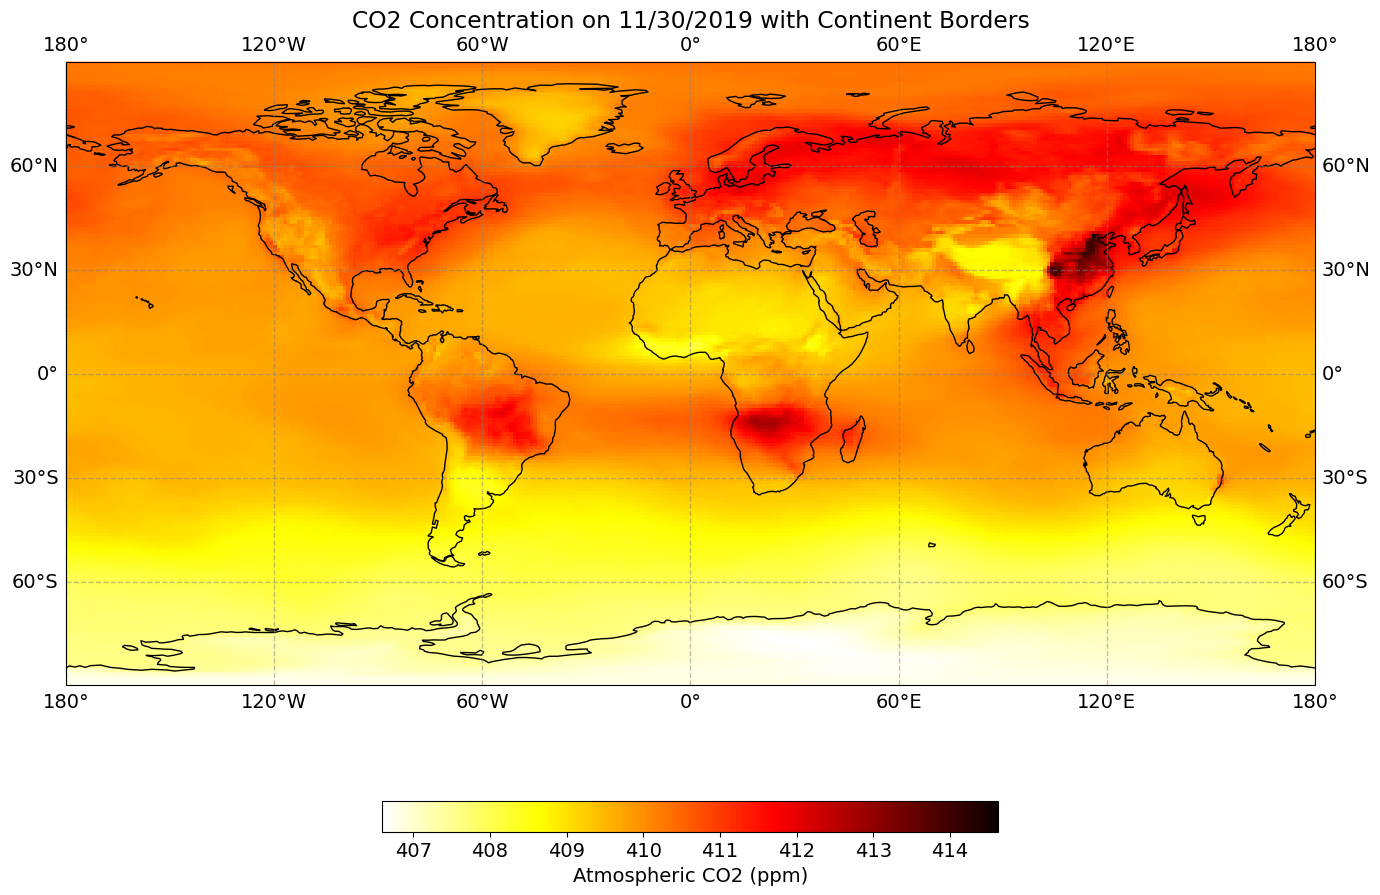

In [41]:
fig = plt.figure(figsize=(20, 10))                                              #establishes a figure and sets the size
ax = plt.axes(projection=ccrs.PlateCarree())                                    #sets up axes & turns the lon-lat into a flat map
ax.axes.add_feature(cf.COASTLINE)                                               #adds boundaries for the coastlines

## we learned this in the section above!-- added ax=ax and removed color bar so we can make a custom one (see below)
your_output = map.plot(cmap = 'hot_r', ax=ax, add_colorbar = False)
ax.set_title("CO2 Concentration on 11/30/2019 with Continent Borders")

cb = plt.colorbar(your_output, fraction=0.04, orientation='horizontal')         #make a custom color bar that looks better than the default
cb.set_label("Atmospheric CO2 (ppm)")                                             #label the color bar including units
ax.set_aspect(1)                                                                #ensure that the axes are not out of proportion to one another

#put in faint grid lines for reference
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color='gray',
    alpha=0.5,
    linestyle='--'
)

**b) In Class (work & discuss in groups):** One way to determine which countries are responsible for significant emissions of CO<sub>2</sub> is to assume that a higher concentration of CO<sub>2</sub> above the country means greater emissions.

In the code below, we define the bounds of each country, then average over all time the measured CO<sub>2</sub> concentration data. The resulting dataframe has the country name and the average concentration of CO<sub>2</sub> above that country.

In [59]:
# Function for determining average co2 over each country
# You do not need to understand this

from shapely.geometry import mapping
import cartopy.crs as ccrs
import rioxarray

#import requisit packages and read file from repository
import geopandas as gpd
gdf_boundaries = gpd.read_file("./taking_the_pulse_atmosphere_data/world-administrative-boundaries.geojson")

# set the index of the dataset to be the country names for easy access
country_names = np.sort(gdf_boundaries.name.values)
gdf_boundaries = gdf_boundaries.set_index('name')

def country_clipped_averages(dataset,bounds):
    '''Function that takes in dataset and gdf_boundaries and returns dataframe
    of average value of co2 over that country.
    Example of use: c_vals = country_clipped_averages(co2_data, gdf_boundaries)'''
    country_vals = pd.DataFrame(index=bounds.index)
    country_vals.co2 = 0
    country_names = gdf_boundaries.index
    for country in country_names:
      data_copy = dataset
      country_boundary = bounds.loc[[country]]
      country_boundary.crs
      data_copy.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
      data_copy.rio.write_crs(4326, inplace=True)
      try:
        data_clipped = data_copy.rio.clip(
            country_boundary.geometry.apply(mapping),
            country_boundary.crs,
            drop=True
        )
      except:
        country_vals.drop('Cyprus')
        pass
      country_vals.at[country, 'co2'] = float(data_clipped.co2.mean(dim=['lon','lat','time']))
    return country_vals

In [58]:
# We are calling the function to tell us how much co2 is in each country
# This function takes a while to run, be patient
c_vals = country_clipped_averages(co2_data, gdf_boundaries);

# sort values and look at the top 10 countries
c_vals.sort_values('co2',ascending=False).head(10)

,co2
name,
Guadeloupe,409.149043
Taiwan,409.149043
Montserrat,408.935868
Republic of Korea,408.935868
Lao People's Democratic Republic,408.691470
Vietnam,408.639173
Japan,408.586088
Thailand,408.502008
Bangladesh,408.468565


The following code cell plots these values

Text(0.5, 1.0, 'Average CO2 Concentration by Country')

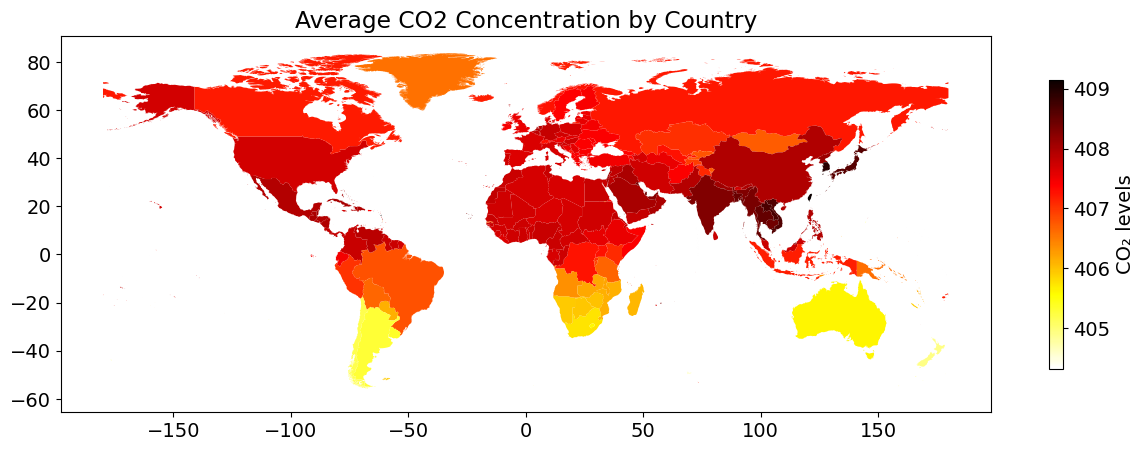

In [60]:
#add average co2 values to the geospatial dataframe
gdf_boundaries.insert(0, 'co2', c_vals['co2'])

#plot all countries with the color corresponding to the co2 average value for that country
ax = gdf_boundaries.plot(column='co2', cmap='hot_r',figsize = (15,15), legend = True, legend_kwds={
        'label': "CO₂ levels",
        'orientation': "vertical",
        'shrink': 0.25});
ax.set_title("Average CO2 Concentration by Country")

Is this approach a good way of determining the sources of CO<sub>2</sub>? Are these countries the top emitters in the world? Discuss (5-8 sentences). A color map labelled by country is in Canvas.

No, the countries with the greatest atmospheric CO2 are not necessarily the top emitters in the world. For one, the satellite is recording the CO2 in the air, not on the ground. Atmospheric mixing and wind patterns, including the correlois effect, can spread the CO2 emitted from the ground and not reflect which country the CO2 came from (i.e., the emitter). In fact, the resolution of this satellite is pretty large (around 55km x 55km), so it is harder to pin point where the CO2 is actually coming from.

Also, there is no distinction made in this data between anthropogenic CO2 and natural CO2 sources. So, a country could just naturally have a lot of CO2 in its atmosphere as a product of not having a large forest, for example (or other carbon sinks), and this would not reflect the human activities (like industrialization) that emit CO2.

Finally, we see that this list biases smaller countries and those that are really dense. This is because larger countries (USA, India, China) have more land and less populated regions where there is likely less CO2 emissions even though they certainly emit the most CO2 in total across the world.

**c) Outside of Class:** Do some research to see what others have suggested as the primary sources of emissions, and the methods they use to quantify emissions. As one example, take a look at this website: https://climatetrace.org/. Explain the methods they are using.

The primary sources of emissions globally is the energy sector (which relies heavily on burning fossil fuels), agriculture, manufacturing, and forestry/land use changes. Some of the top emitting countries are China, the US, India, and Brazil.

Other methods to quantify emissions include using on-the-ground and airborne sensors in likely sources of emission and high-emitting countries. On the one hand, this allows for a much finer resolution than the satellite data for more accurate CO2 detection, but it not only is lacking in terms of spatial coverage around the globe, but also requires funding and the active cooperation of the countries under scrutiny.

Climate Trace is measuring CO2 by using satellite and other data to locate likely sources of emission. Then, they use models, often informed by ground and airborne sensors, to estimate the emissions in these high human activity areas. This involves math using emission factors and climate modelling. They have done these calculations for 10+ years across 10 sectors and 662,637,077 emitting assets (power plant, oil field, steel mill, cargo ships, etc). They are also examining other GHGs and creating a dynamic map of the spread of PM2.5 from high emitters through weather data.

**d) Outside of Class:** Given the results of your analysis, and what you have learned, what do you conclude about the source of emissions? What other data/information would you like to have in order to have a higher level of confidence in your conclusions? (10-15 sentences)

Although there is certainly a fairly confident correlation between the atmospheric CO2 present in a place and its emissions, atmospheric CO2 from satellite data can not be used in replacement of or to conclude the largest sources of emission in the world. This is because for one, satellites are recording the CO2 in the air, not on the ground. Atmospheric mixing and wind patterns, including the correlois effect, can spread the CO2 emitted from the ground and not reflect which country the CO2 came from (i.e., the emitter). In fact, the resolution of this satellite is pretty large (around 55km x 55km), so it is harder to pin point where the CO2 is actually coming from.

Also, there is no distinction made in this data between anthropogenic CO2 and natural CO2 sources. So, a country could just naturally have a lot of CO2 in its atmosphere as a product of not having a large forest, for example (or other carbon sinks), and this would not reflect the human activities (like industrialization) that emit CO2.

For this reason, we need more information to have a higher level of confidence in our conclusions, especially having more of a granular resolution on data collected for more accurate CO2 recordings within a specific location and more emphasis on examining human activities to single out specifically anthropogenic CO2.

I learned that other methods to quantify emissions include using on-the-ground and airborne sensors in likely sources of emission and high-emitting countries. On the one hand, this allows for a much finer resolution than the satellite data for more accurate CO2 detection, but it not only is lacking in terms of spatial coverage around the globe, but also requires funding and the active cooperation of the countries under scrutiny.

I really liked Climate Trace's approach since it leveraged ground sensors, satellite data, and math-based models to estimate the emissions in high human activity areas. This involves math using emission factors and climate modelling. They have done these calculations for 10+ years across 10 sectors and 662,637,077 emitting assets (power plant, oil field, steel mill, cargo ships, etc).

Ultimately, leveraging a combination of more granular data from sensors and zoomed-out satellite data along with mathematical modelling of weather patterns and typical emissions factors can help lead to more accurate understandings of human emissions. This will drive policy and put pressure on countries that need to take more immediate action.

**e) Outside of Class:** In addition to sources of CO<sub>2</sub>, do you see evidence of sinks of CO<sub>2</sub>? How do you interpret these sinks? (4-6 sentences)

Yes, we are able to see sinks, or areas marked by generally lower atmospheric CO2 concentrations. For one thing, Brazil is one of the largest emitters, but the scale of its emissions isn't necessarily reflected in the maps because the Amazon Rainforest is a major carbon sink.

Similarly, we see from the maps that the oceans have less atmospheric CO2 over them, especially closer to the extreme poles. Oceans typically act as natural sinks, absorbing CO2 into the deep water.

#### **3) HOW IS CO<sub>2</sub> VARYING OVER TIME?**
If we are interested in how CO<sub>2</sub> concentration is varying in time:

**a) In Class (work & discuss in groups):**  Let's start by selecting one location and look at a time series, over a selected time window, generating a plot as you did with the Mauna Loa data in Assignment 1.

Text(0.5, 1.0, 'CO2 Concentration Near Stanford')

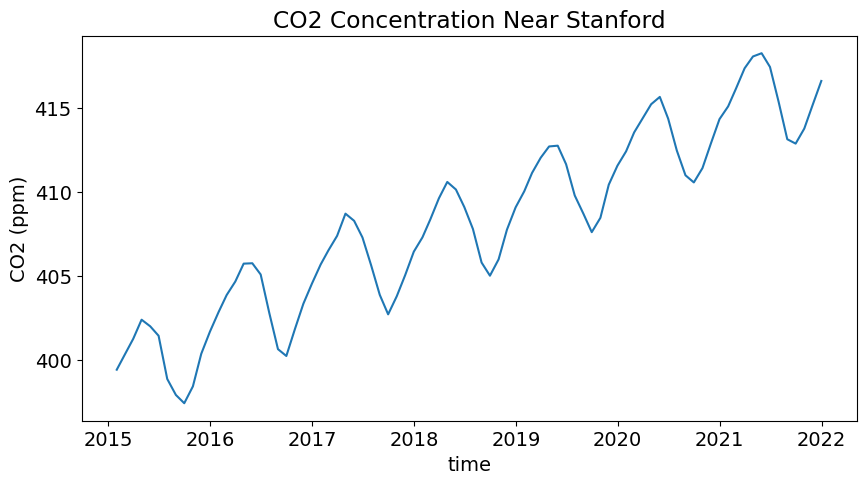

In [65]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
your_location_data = co2_data.co2.sel(lat = 37, lon = -122, method = 'nearest')

your_location_data.plot(ax=ax)
ax.set_ylabel("CO2 (ppm)")
ax.set_title("CO2 Concentration Near Stanford")

**b) In Class (work & discuss in groups):** If we want to visualize how CO<sub>2</sub> concentration is varying with time in all locations, a useful way to visualize this is to reduce each time series to a single value so that we have a map showing the *RATE OF CHANGE* [the trend] in CO<sub>2</sub> concentration over all time.

In [67]:
##### Function Code Block ########
##### you should not need to edit this code block ####

#run this code block to generate a function that we can use to take the linear fit
def linear_fit(time_series, data):
    # assume the time series has a regular sampling rate
    times = np.arange(len(time_series))
    G = np.c_[times, np.ones_like(times)]
    Pinv = np.linalg.pinv(G)
    m = Pinv.dot(data)
    predicted_data = G @ m
    slope = m[0,:]
    intercept = m[1,:]
    return predicted_data, slope, intercept

In [68]:
# in this example we are using the data category 'co2'
# if you want to look at a different data category make sure to change this before running the code
your_data_grid = co2_data.co2.data.reshape((co2_data.co2.data.shape[0], np.prod(co2_data.co2.data.shape[1:]))) # makes the 2d grid into a column vector where each index of the column is a location on the map
your_time_series = pd.to_datetime(co2_data.time.data)                                                                            # pulls the time steps

co2_linear_fit, slope, intercept = linear_fit(your_time_series, your_data_grid)                                                           #makes linear fits for every location

# Add results back to your_gridded_data
co2_data['slope'] = (("lat", "lon"), slope.reshape(co2_data.co2.data.shape[1:]))                                        # makes a new 'slope' dataset in the dataframe
co2_data['intercept'] = (("lat", "lon"), intercept.reshape(co2_data.co2.data.shape[1:]))                                # makes a new 'intercept' dataset in the dataframe
co2_data['co2_linear_fit'] = (("time", "lat", "lon"), co2_linear_fit.reshape(co2_data.co2.data.shape))                  # incorperates the predicted points into the dataframe

# pulls out the date range and reformats it to a useful format for printing
time_min = pd.to_datetime(your_time_series).min().strftime('%Y-%m')
time_max = pd.to_datetime(your_time_series).max().strftime('%Y-%m')



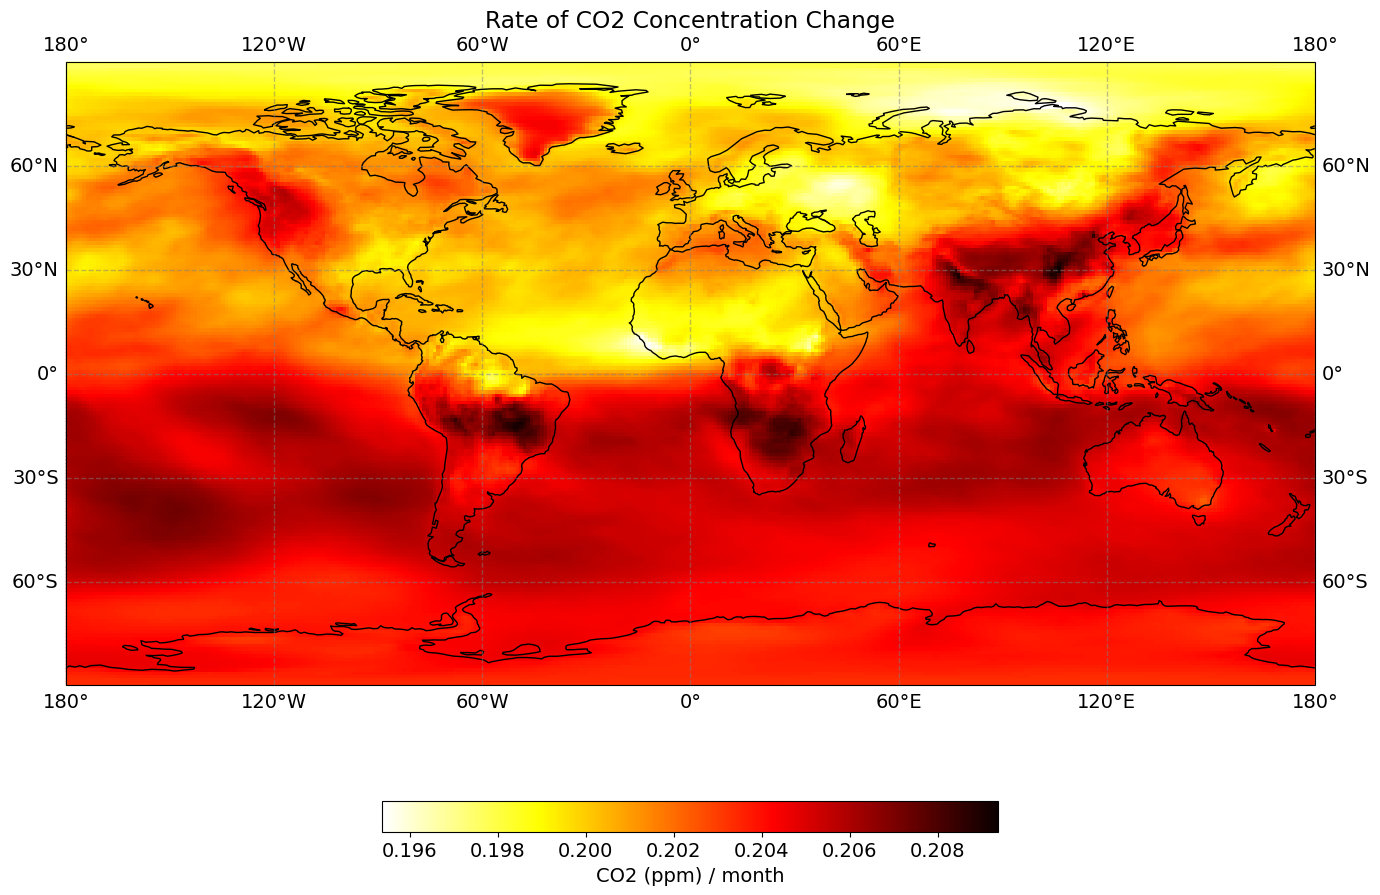

In [69]:
fig = plt.figure(figsize=(20, 10))                                              #establishes a figure and sets the size
ax = plt.axes(projection=ccrs.PlateCarree())                                    #sets up axes & turns the lon-lat into a flat map
ax.axes.add_feature(cf.COASTLINE)                                               #adds boundaries for the coastlines

## we learned this in the section above!-- added ax=ax and removed color bar so we can make a custom one (see below)
your_output = co2_data.slope.plot(cmap = 'hot_r', ax=ax, add_colorbar = False)

cb = plt.colorbar(your_output, fraction=0.04, orientation='horizontal')         #make a custom color bar that looks better than the default
cb.set_label("CO2 (ppm) / month")                                             #label the color bar including units
ax.set_aspect(1)                                                                #ensure that the axes are not out of proportion to one another
ax.set_title("Rate of CO2 Concentration Change")

#put in faint grid lines for reference
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    color='gray',
    alpha=0.5,
    linestyle='--'
)

#### **4) ADVANTAGES AND DISADVANTAGES OF SATELLITE CO<sub>2</sub> MEASUREMENTS**

##### **a) Outside of Class:** Compare the satellite data nearest to Mauna Loa to your findings from Assignment 1 by plotting that pixel over time on the same plot as the monthly CO<sub>2</sub> data from the NOAA dataset (Mauna Loa). Plot only the years of Mauna Loa data that are also covered by the satellite data.

*Hint: Convert the gridded CO2 data at Mauna Loa into a pandas dataframe by using:* `your_gridded_data.to_dataframe()`


In [70]:
#Downloading Dataset from Redivis - Mauna Loa

user = redivis.user("sdss")
dataset = user.dataset("geophysics_115_taking_the_pulse_of_the_planet:fg2x:v1_0")
table = dataset.table("atmosphere_data:9be7")

# Load table as a dataframe
df = table.to_pandas_dataframe(max_results=100)
df.head()

# This table contains file references, to download:
table.download_files('./taking_the_pulse_atmosphere_data/',overwrite=True)

# pull the data from the server into a useful pandas format
df_co2 = pd.read_csv('./taking_the_pulse_atmosphere_data/co2_gml.csv')
# df_co2 = pd.read_csv('./homework-data/co2_global.csv')

#-----------------------------------#
# GENERATE DATE FROM MONTHS + YEARS
import datetime

#reorganizing datetime objects
years = df_co2['year'].values.astype(int)
months = df_co2['month'].values.astype(int)
times = [datetime.date(years[ii], months[ii], 1) for ii in range(df_co2.shape[0])]
time_series = pd.to_datetime(times)

# set index to be datetime object
df_co2['time'] = time_series
df_co2.set_index('time',drop=False,inplace=True);

df_co2

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ? files/s]

0.00 (?B/s)

,year,month,monthly_average_co2,de-seasonalized_co2,time
time,,,,,
1958-03-01,1958.0,3.0,315.70,314.43,1958-03-01
1958-04-01,1958.0,4.0,317.45,315.16,1958-04-01
1958-05-01,1958.0,5.0,317.51,314.71,1958-05-01
1958-06-01,1958.0,6.0,317.24,315.14,1958-06-01
1958-07-01,1958.0,7.0,315.86,315.18,1958-07-01
...,...,...,...,...,...
2022-07-01,2022.0,7.0,418.90,418.59,2022-07-01
2022-08-01,2022.0,8.0,417.19,419.16,2022-08-01
2022-09-01,2022.0,9.0,415.95,419.50,2022-09-01


In [75]:
df_co2 = df_co2.loc['2015':'2021']  # selecting the correct years for the Mauna Loa data

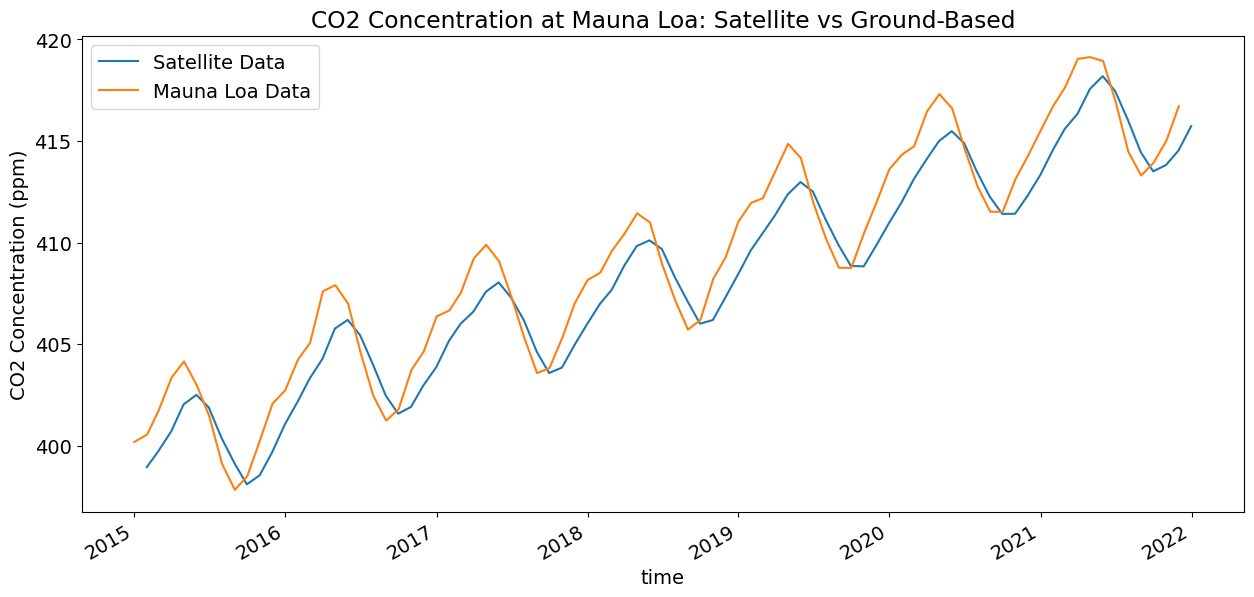

In [76]:
your_location_data = co2_data.co2.sel(lat = 20, lon = -155, method = 'nearest') # at Mauna Loa location - satellite data
fig, ax = plt.subplots(1,1, figsize=(15, 7))
your_location_data.plot(ax=ax, label='Satellite Data')
df_co2.plot(y='monthly_average_co2', ax=ax, label='Mauna Loa Data')
ax.set_ylabel("CO2 Concentration (ppm)")
ax.set_title("CO2 Concentration at Mauna Loa: Satellite vs Ground-Based")
ax.legend()

##### **b) Outside of Class:** Describe the differences and similarities observed in part a. What do you think causes these differences? Given your observations, discuss the advantages and disadvantages of satellite vs ground based measurements.
(write the equivelent of 1 page on these topics)

The graphs are very similar, recording CO2 concentrations within a single ppm of each other in most cases. They follow the same sinusodial pattern, which suggests seasonality to CO2 concentrations, and is upward trending throughout the years. So, the underlying trend is supported by both the satellite and ground data: CO2 levels are going up!

However, the data is also different in some ways. For example, the satellite data (in the blue) often underrecords the data. While it is true that satellites are able to cover much more spatially, they also get much less fine-tuned data especially with a large resolution and within a specific area like Mauna Loa. Therefore, it is possible for the satellite to have missed a few particles of CO2 and underrepresent the data.

In general, we know that satellite data can be more inaccurate in specific locations because the satellite is recording the CO2 in the air, not on the ground. Atmospheric mixing and wind patterns, including the correlois effect, can spread the CO2 emitted from the ground, so the data doesn't have to reflect where specifically the CO2 came from.

However, sensors on the ground like the direct Mauna Loa data is obviously unable to capture data for the entire planet, like the satellite can, and requires more capital investment and cooperation, but it is likely more accurate within a specific location. Even though Mauna Loa is also recording atmospheric CO2, it is closer to the ground, meaning it can record the CO2 that is directly emitted from the region with more accuracy and a finer resolution.

Finally, although the data is very similar, the two lines in the graph felt almost staggered by a couple units of time. I wonder if this speaks to the lower temporal resolution of satellites since they cannot be over all places around the globe at once.

I know that the OCO-2 satellite is relatively quick and the measurements are being averaged over a large scale of time, but I wonder if the satellite misses some measurements or isn't updating this information in real time, which would explain the slight offset in data. Another explanation could just be that the coordinates for Mauna Loa that I inputed for the satellite data is a bit off or doesn't cover Mauna Loa in the center of its roughly 55km x 55km resolution.


##### **bonus:** If you want to learn more about how what you have done in this assignment relates to how atmospheric scientists are attempting exactly what you have described and investigated in this assignment check out the following links. I reccomend at least reading the first one.

1. General audience press release about JPL's conclusions about carbon emissions by country: https://www.jpl.nasa.gov/news/nasa-space-mission-takes-stock-of-carbon-dioxide-emissions-by-countries

2. Intermediate step in the data analysis where they have included bottom up information and describe how they use it: https://ceos.org/gst/carbon-dioxide.html

3. Scientific paper describing thouroughly the methods and approaches used with description of the tradeoffs made: https://essd.copernicus.org/articles/15/963/2023/